In [1]:
import os

print(os.getcwd())

import torch
from src.manipulator._style_gan_manipulator.legacy import load_network_pkl

import matplotlib.pyplot as plt
plt.style.use('dark_background')
# ==== load StyleGAN's mapping and synthesis networks ====
# mapping: z -> w (shape: [1, latent_dim] -> [1, num_layers, 512])
# synthesis: takes per-layer w
# f = open("local_models/generators/imagenet128.pkl", "rb")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device ", device)
ckpt_path = "../local_models/generators/stylegan2-car-config-f.pkl"
# load generator

with open(ckpt_path, 'rb') as f:
    generator = load_network_pkl(f)['G_ema'].to(device)  # type: ignore


/tmp/pycharm_project_181
device  cuda


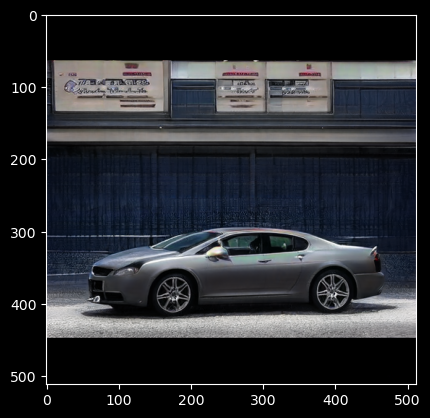

In [21]:
# generate latent vector and class label
z = torch.randn([1, generator.z_dim], device=device)

if generator.c_dim != 0:
    label = torch.zeros([1, generator.c_dim], device=device)

    target_class = 15  #  SELECT CLASS
    label[:, target_class] = 1
else:
    label = None

img_tensor = generator(z, label, truncation_psi=0.5, noise_mode='const')
img_tensor = (img_tensor.clamp(-1, 1) + 1) / 2  # normalize to [0, 1] ss

from torchvision.utils import save_image
save_image(img_tensor, 'stylegan_car.png')
img_tensor_temp = img_tensor.clone()
img = img_tensor_temp.cpu().detach().numpy()[0]
img = img.transpose(1, 2, 0)

plt.imshow(img)



In [22]:
img.shape

(512, 512, 3)

In [23]:
from ultralytics import YOLO
import cv2
# 1. 加载模型（你可以换成 yolov8s.pt、yolov8m.pt、yolov8l.pt、yolov8x.pt）
yolo_model = YOLO("yolov8n.pt")  # 使用 nano 模型，轻量级

# 进行预测
results = yolo_model(img_tensor)


# 输出结果内容
for box in results[0].boxes:
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    label = yolo_model.names[cls_id]
    print(f"Detected: {label} ({conf:.2f})")


0: 512x512 1 car, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 3.9ms postprocess per image at shape (1, 3, 512, 512)


Detected: car (0.91)


Test classifiers

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


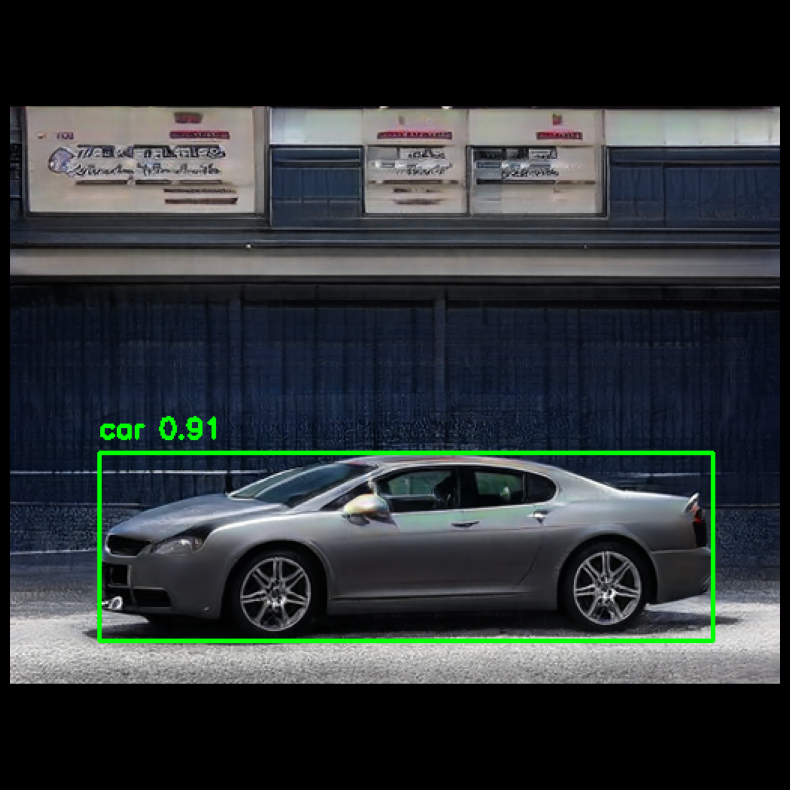

In [24]:
# 解析预测框
boxes = results[0].boxes  # Boxes 对象
xyxy = boxes.xyxy.cpu().numpy()       # [x1, y1, x2, y2]
conf = boxes.conf.cpu().numpy()       # 置信度
cls_ids = boxes.cls.cpu().numpy()     # 类别ID
names = yolo_model.names                   # 类别名称字典
img_for_draw = img.copy()
# 可视化
for i in range(len(xyxy)):
    x1, y1, x2, y2 = map(int, xyxy[i])
    label = f"{names[int(cls_ids[i])]} {conf[i]:.2f}"
    cv2.rectangle(img_for_draw, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_for_draw, label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# 显示
plt.figure(figsize=(10, 10))
plt.imshow(img_for_draw)
#plt.imshow(cv2.cvtColor(img_for_draw, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [25]:
# from ultralytics.utils.torch_utils import preprocess as preprocess_yolo
import torch
# compute raw predictions
#with torch.no_grad():
from torchvision import transforms
#preprocess_yolo = transforms.Compose([
#    transforms.Resize((640, 640))
#    ])
yolo_model.model = yolo_model.model.to(device)
pred = yolo_model.model(img_tensor)[0].squeeze(0).T  # shape: [num_preds, 85]
print(pred.shape)
# 前 4 个是 [x_center, y_center, w, h]
boxes_xywh = pred[:, :4]

# 第 5 个是 objectness
# objectness = pred[:, 4]
# print(objectness)
# 后面是 class logits
class_scores = pred[:, 4:]  # shape: (num_preds, num_classes)

# objectness = pred[:, 4]                     # shape: [5376] no objectness
class_probs = pred[:, 4:]                   # shape: [5376, 79]
confidences = class_probs.max(1).values  # shape: [5376]

top_idx = confidences.argmax()
top_class = class_probs[top_idx].argmax()
top_conf = confidences[top_idx]


torch.Size([5376, 84])


In [26]:
yolo_model.names[int(top_class)]

'car'

In [27]:
pred[top_idx][4+top_class]

tensor(0.9107, device='cuda:0')

In [28]:
pred[top_idx]

tensor([2.6337e+02, 3.5685e+02, 4.0839e+02, 1.2436e+02, 2.2585e-08, 1.4275e-05, 9.1074e-01, 2.6449e-05, 4.7622e-04, 1.7790e-06, 2.6819e-06, 1.0468e-04, 1.1675e-05, 1.9315e-07, 1.4821e-07, 6.3682e-08, 1.6826e-05, 3.3505e-05, 2.5152e-06, 7.8624e-07, 7.7082e-08, 8.0768e-07, 6.4321e-07, 1.3658e-05, 1.5820e-08, 2.7653e-06,
        1.3586e-07, 6.9893e-09, 2.3780e-07, 1.9332e-05, 6.3511e-07, 7.5230e-10, 1.7330e-06, 6.1967e-07, 1.0746e-07, 4.7647e-07, 3.7189e-06, 2.8948e-09, 1.2672e-06, 5.5875e-08, 2.0803e-07, 8.5437e-06, 1.0970e-07, 3.4704e-05, 1.2969e-07, 1.2401e-07, 1.1032e-06, 1.2923e-07, 3.8987e-06, 4.3784e-06, 8.0746e-07, 5.4642e-06,
        6.6764e-08, 1.7516e-08, 1.2904e-04, 2.7874e-08, 1.0185e-07, 1.9676e-09, 2.0932e-07, 9.0920e-08, 1.9060e-07, 1.4907e-05, 3.4090e-06, 4.9975e-06, 3.2185e-07, 5.1727e-07, 8.9726e-06, 2.2741e-06, 6.3637e-05, 2.2971e-06, 8.3891e-05, 2.7238e-06, 1.3918e-06, 1.6705e-05, 2.5671e-06, 2.9122e-04, 4.0421e-07, 2.6799e-07,
        2.9630e-08, 1.2901e-07, 9.5190e-

In [29]:
img_tensor.shape

torch.Size([1, 3, 512, 512])

In [30]:
yolo_for_gradients = YOLO("yolov8n.pt")
#yolo_for_gradients.model.eval()
input_tensor = img_tensor.clone().to(device)
input_tensor.requires_grad = True
yolo_for_gradients.model.to(device)
output = yolo_for_gradients.model(input_tensor)
output = output[0].squeeze(0).T

conf = output[top_idx][4+top_class]

# 7. 反向传播
conf.backward()

# 8. 得到输入图像梯度
input_grad = input_tensor.grad  # shape [1, 3, 640, 640]


In [31]:
print(output - pred)


tensor([[ 3.3379e-06,  9.5367e-06,  6.6757e-06,  ...,  2.6716e-12,  3.4106e-13,  1.1369e-12],
        [ 5.7220e-06,  1.6689e-05,  1.1444e-05,  ...,  3.9222e-12,  1.3074e-12,  9.9476e-13],
        [-7.6294e-06,  7.6294e-06,  0.0000e+00,  ...,  2.1032e-12,  1.3358e-12,  8.5265e-13],
        ...,
        [-1.2207e-04,  0.0000e+00,  2.4414e-04,  ...,  2.3874e-12,  1.3642e-12,  1.1369e-12],
        [-2.4414e-04,  0.0000e+00,  4.8828e-04,  ...,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.2207e-04,  0.0000e+00,  1.2207e-04,  ..., -3.7517e-12,  0.0000e+00,  0.0000e+00]], device='cuda:0', grad_fn=<SubBackward0>)


In [16]:
seg_model = YOLO("../local_models/segmentation/carparts_segment/carparts_seg_4gpu/weights/best.pt")  # load a pretrained model (recommended for training)

seg_results = seg_model(img_tensor)
print(seg_results[0].masks.data.sum())


0: 512x512 2 back_bumpers, 1 back_glass, 1 back_left_door, 1 back_right_door, 1 front_right_door, 1 right_mirror, 3 wheels, 19.6ms
Speed: 0.0ms preprocess, 19.6ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 512)


tensor(32435., device='cuda:0')


In [17]:
type(img)

numpy.ndarray

In [18]:
from local_models.segmentation.segmentation_handler_yolo import YOLOSegmentationModel
segmenter = YOLOSegmentationModel("../local_models/segmentation/carparts_segment/carparts_seg_4gpu/weights/best.pt", conf_threshold=0.5)
seg_result_c = segmenter.predict(img_tensor)
seg_result_c

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/ultralytics/nn/tasks.py:527: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location

YOLO segmentation model loaded on cuda.


TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
print(
    f"Confidence: {seg_results[0].conf:.2f}, "
    f"Class: {seg_results[0].cls}, "
)
(seg_result_c[0].masks.data - seg_results[0].masks.data).sum()

In [32]:
print(seg_result[0].masks)

None


In [24]:
segmenter.model.predict(img_tensor)


0: 512x512 1 right_mirror, 3 wheels, 17.1ms
Speed: 0.1ms preprocess, 17.1ms inference, 4.1ms postprocess per image at shape (1, 3, 512, 512)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'back_bumper', 1: 'back_door', 2: 'back_glass', 3: 'back_left_door', 4: 'back_left_light', 5: 'back_light', 6: 'back_right_door', 7: 'back_right_light', 8: 'front_bumper', 9: 'front_door', 10: 'front_glass', 11: 'front_left_door', 12: 'front_left_light', 13: 'front_light', 14: 'front_right_door', 15: 'front_right_light', 16: 'hood', 17: 'left_mirror', 18: 'object', 19: 'right_mirror', 20: 'tailgate', 21: 'trunk', 22: 'wheel'}
 orig_img: array([[[ 0,  0,  0],
         [ 2,  0,  0],
         [ 2,  0,  0],
         ...,
         [ 1,  1,  0],
         [ 6,  5,  3],
         [11, 11,  7]],
 
        [[ 0,  0,  0],
         [ 4,  0,  1],
         [ 2,  0,  0],
         ...,
         [ 1,  1,  0],
         [ 3,  2,  1],
         [ 0,  0,  0]],
 
        [[ 1,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,

In [ ]:
from local_models.segmentation.segmentation_handler_yolo import YOLOSegmentationModel